## 1. Data Upload

In [1]:
import pandas as pd
import numpy as np
from io import StringIO
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

path_csv = '.'

# Read the CSV files into pandas dataframes
input_formal_model = pd.read_csv(f"{path_csv}/formal_model.csv")

In [2]:
input_formal_model

,Formal Model,f1,f2,f3,f4,f5
0,1,2.8,-1.8,-2.800000,1.300000,0.4
1,2,2.9,-1.9,-2.900000,1.400000,0.5
2,3,3.0,-2.0,-3.000000,1.500000,0.6
3,4,3.1,-2.1,-3.100000,1.600000,0.7
4,5,3.2,-2.2,-3.200000,1.700000,0.8
5,6,-1.6,-2.5,1.500000,0.200000,0.6
6,7,-1.3,-2.7,1.300000,0.400000,0.8
7,8,-1.0,-3.0,1.500000,0.600000,1.0
8,9,-0.7,-3.2,1.700000,0.800000,1.2
9,10,-0.5,-3.5,1.900000,1.000000,1.4


## 2. Multi-dimensional scaling

In [3]:
# Drop the 'Formal Model' column as it's an identifier and not part of the features
formal_model_values = input_formal_model.drop('Formal Model', axis=1)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(formal_model_values)

# Apply MDS to reduce the dimensions to 2
mds = MDS(n_components=2, normalized_stress='auto')
X_mds = mds.fit_transform(X_scaled)

# Convert the reduced data back to a pandas DataFrame
formal_model_reduced = pd.DataFrame(X_mds, columns=["x1", "x2"])


In [4]:
formal_model_reduced

,x1,x2
0,-0.803368,1.824154
1,-0.716844,1.996093
2,-0.656769,2.170627
3,-0.534348,2.341301
4,-0.474309,2.517496
5,1.667394,-1.104904
6,1.753247,-0.711248
7,2.014518,-0.360857
8,2.225628,-0.060553
9,2.554670,0.231108


## 3. Visual analytics

In [5]:
def interpolate_coordinates(x_1, x_n, n):
    """
    This function calculates the values of the interpolate_coordinates
    of a line based on its first and last coordinates.
    :param x_1:
    :param x_n:
    :param n:
    :return:
    """
    # Ensure n is greater than 1 to avoid division by zero
    if n <= 1:
        raise ValueError("n must be greater than 1 to calculate intermediate points.")

    # List to hold all the coordinates including the first and the last
    inter_coordinates = []

    # Calculate each intermediate coordinate
    for i in range(0, n):
        x_i = x_1 + ((x_n - x_1) * i) / (n - 1)
        inter_coordinates.append(x_i)

    return inter_coordinates


In [26]:
x_1_first = 2
x_1_last = -3
x_2_first = -2
x_2_last = 2
num_points = 5

x_1_inter_coordinates = interpolate_coordinates(x_1_first, x_1_last, num_points)
x_2_inter_coordinates = interpolate_coordinates(x_2_first, x_2_last, num_points)
# print(x_1_inter_coordinates)
# print(x_2_inter_coordinates)

# Create a DataFrame from the coordinates
coordinates_df = pd.DataFrame({'x1': x_1_inter_coordinates, 'x2': x_2_inter_coordinates})
coordinates_df


,x1,x2
0,2.00,-2.0
1,0.75,-1.0
2,-0.50,0.0
3,-1.75,1.0
4,-3.00,2.0


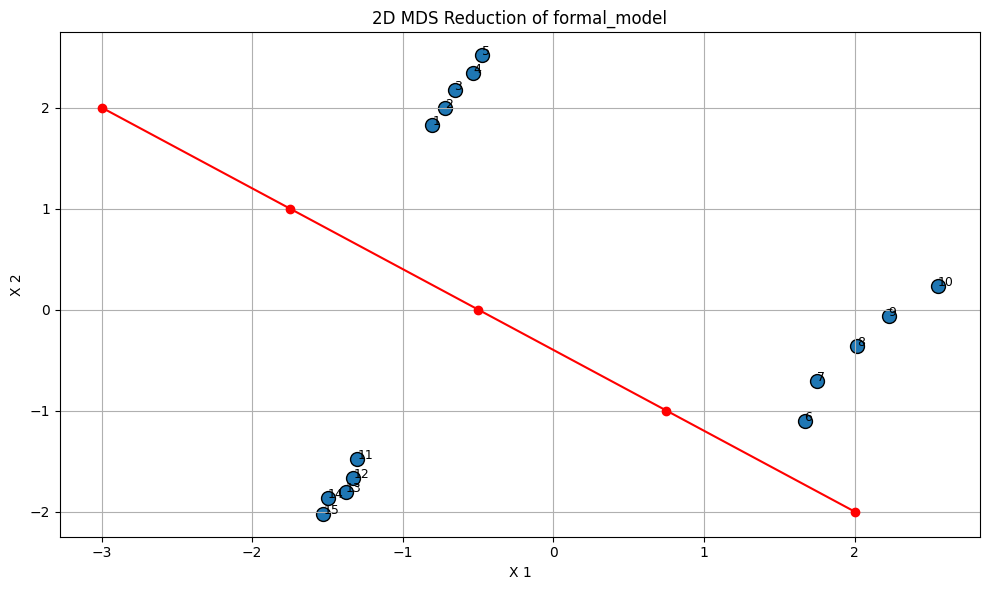

In [27]:
import matplotlib.pyplot as plt

# Scatter plot for the reduced data
plt.figure(figsize=(10, 6))
plt.scatter(formal_model_reduced['x1'], formal_model_reduced['x2'], s=100, edgecolor='k')
for i, txt in enumerate(input_formal_model['Formal Model']):
    plt.annotate(txt, (formal_model_reduced['x1'].iloc[i], formal_model_reduced['x2'].iloc[i]), fontsize=9)

# Draw the separating line
line_x1 = coordinates_df['x1'].tolist()
line_x2 = coordinates_df['x2'].tolist()
plt.plot(line_x1, line_x2, 'ro-')

plt.xlabel("X 1")
plt.ylabel("X 2")
plt.title("2D MDS Reduction of formal_model")
plt.grid(True)
plt.tight_layout()
plt.show()


## 4. Calculate Transition Matrix

### 3.1. Singular Value Decomposition (SVD)

In [29]:
# Receive values from the matrix A DataFrame 
formal_model_reduced_values = formal_model_reduced.values

# Calculate SVD
U, s, Vt = np.linalg.svd(formal_model_reduced_values)

# Construct the full diagonal matrix
S = np.zeros(formal_model_reduced_values.shape)
for i in range(min(formal_model_reduced_values.shape)):
    S[i, i] = s[i]

# print("U:\n", U)
# print("\nS:\n", S)
# print("\nVt:\n", Vt)


### 3.2. Create the reconstructed matrix of SVD

In [30]:
# Recompute the original matrix using U, S, and Vt
reconstructed_matrix = U.dot(S.dot(Vt))

# Convert the reconstructed matrix to a pandas DataFrame, if desired
reconstructed_df = pd.DataFrame(reconstructed_matrix)


In [31]:
reconstructed_df

,0,1
0,-0.803368,1.824154
1,-0.716844,1.996093
2,-0.656769,2.170627
3,-0.534348,2.341301
4,-0.474309,2.517496
5,1.667394,-1.104904
6,1.753247,-0.711248
7,2.014518,-0.360857
8,2.225628,-0.060553
9,2.554670,0.231108


In [32]:
formal_model_reduced

,x1,x2
0,-0.803368,1.824154
1,-0.716844,1.996093
2,-0.656769,2.170627
3,-0.534348,2.341301
4,-0.474309,2.517496
5,1.667394,-1.104904
6,1.753247,-0.711248
7,2.014518,-0.360857
8,2.225628,-0.060553
9,2.554670,0.231108


### 3.3. Calculate the generalized inverse of input matrix

In [33]:
# Calculate the generalized (Moore-Penrose) inverse
formal_model_reduced_pinv = np.linalg.pinv(formal_model_reduced_values)

# Convert to a pandas DataFrame
formal_model_reduced_pinv_df = pd.DataFrame(formal_model_reduced_pinv)

In [34]:
formal_model_reduced_pinv_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.027279,-0.024976,-0.023471,-0.020087,-0.018586,0.052002,0.053904,0.061151,0.066977,0.076362,-0.036547,-0.037015,-0.038260,-0.041785,-0.042392
1,0.045448,0.049452,0.053565,0.057477,0.061630,-0.029561,-0.020200,-0.012185,-0.005295,0.001184,-0.033430,-0.038096,-0.041338,-0.042439,-0.046212


### 3.4. Calculate transition matrix T

In [35]:
transition_matrix_T = formal_model_reduced_pinv_df.dot(formal_model_values)

In [36]:
transition_matrix_T

,f1,f2,f3,f4,f5
0,-0.834816,-0.519673,0.678551,0.112000,0.845984
1,0.697088,-0.162862,-1.068835,0.466885,0.721341


## 4. Create Hyperplane

In [37]:
coordinates_hyperplane_df = coordinates_df.values @ transition_matrix_T.values

In [38]:
coordinates_hyperplane_df

array([[-3.0638067 , -0.71362231,  3.49477087, -0.70977158,  0.24928708],
       [-1.32319939, -0.22689298,  1.5777478 , -0.38288568, -0.08685249],
       [ 0.41740793,  0.25983635, -0.33927527, -0.05599977, -0.42299205],
       [ 2.15801524,  0.74656568, -2.25629833,  0.27088614, -0.75913162],
       [ 3.89862255,  1.23329501, -4.1733214 ,  0.59777204, -1.09527119]])

In [39]:
# Adding a new column with all values set to 1
new_column = np.ones((coordinates_hyperplane_df.shape[0], 1))
feature_vector_inverse = np.hstack((new_column, coordinates_hyperplane_df))

feature_vector_inverse

array([[ 1.        , -3.0638067 , -0.71362231,  3.49477087, -0.70977158,
         0.24928708],
       [ 1.        , -1.32319939, -0.22689298,  1.5777478 , -0.38288568,
        -0.08685249],
       [ 1.        ,  0.41740793,  0.25983635, -0.33927527, -0.05599977,
        -0.42299205],
       [ 1.        ,  2.15801524,  0.74656568, -2.25629833,  0.27088614,
        -0.75913162],
       [ 1.        ,  3.89862255,  1.23329501, -4.1733214 ,  0.59777204,
        -1.09527119]])

In [40]:
# Optimization criteria function
def optimization_criteria(W, X):
    return np.sum(np.abs(X.dot(W.T)))

# Initial guess (starting point for the optimization algorithm)
weights_inverse_initial = np.zeros(feature_vector_inverse.shape[1])

# Bounds for W (setting it between -1 and 1)
bounds = [(-1, 1) for _ in range(feature_vector_inverse.shape[1])]

# The actual optimization
res = minimize(
    optimization_criteria,
    weights_inverse_initial,
    args=(feature_vector_inverse,),
    method='SLSQP',
    bounds=bounds,
    options={'disp': True}
)

# Checking if the optimization was successful
if res.success:
    # Extract the weights into a DataFrame
    weights_inverse_output = pd.DataFrame(res.x, index=[f'w{i}' for i in range(len(res.x))], columns=['weight'])

    print("Optimization was successful. The weights are:")
    print(weights_inverse_output)

    # Output the value of the optimization criteria
    print("\nValue of the optimization criteria (objective function value):", res.fun)
else:
    print("Optimization failed.")

# Checking for convergence
print("\nConvergence status:", res.message)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.385693766547252e-07
            Iterations: 11
            Function evaluations: 108
            Gradient evaluations: 11
Optimization was successful. The weights are:
      weight
w0 -0.000159
w1 -0.000388
w2 -0.000169
w3 -0.000391
w4 -0.000474
w5 -0.000487

Value of the optimization criteria (objective function value): 5.385693766547252e-07

Convergence status: Optimization terminated successfully


In [41]:
weights_inverse_output

,weight
w0,-0.000159
w1,-0.000388
w2,-0.000169
w3,-0.000391
w4,-0.000474
w5,-0.000487


In [42]:
# Reorder the weight vector so that w0 is at the end.
weights_df_reordered = pd.concat([weights_inverse_output.iloc[1:], weights_inverse_output.iloc[0:1]]).reset_index(drop=True)

# Show the modified DataFrame
weights_df_reordered


,weight
0,-0.000388
1,-0.000169
2,-0.000391
3,-0.000474
4,-0.000487
5,-0.000159


In [43]:
# Create a new DataFrame with an additional column
new_formal_model_values = formal_model_values.copy()
new_formal_model_values['f0'] = 1
new_formal_model_values


,f1,f2,f3,f4,f5,f0
0,2.8,-1.8,-2.800000,1.300000,0.4,1
1,2.9,-1.9,-2.900000,1.400000,0.5,1
2,3.0,-2.0,-3.000000,1.500000,0.6,1
3,3.1,-2.1,-3.100000,1.600000,0.7,1
4,3.2,-2.2,-3.200000,1.700000,0.8,1
5,-1.6,-2.5,1.500000,0.200000,0.6,1
6,-1.3,-2.7,1.300000,0.400000,0.8,1
7,-1.0,-3.0,1.500000,0.600000,1.0,1
8,-0.7,-3.2,1.700000,0.800000,1.2,1
9,-0.5,-3.5,1.900000,1.000000,1.4,1


In [44]:
# # Multiply the features by the weights
my_result = new_formal_model_values.mul(weights_df_reordered['weight'].values, axis=1)

# Sum along the rows to get the final single column for predictions
my_predictions = my_result.sum(axis=1)

# Convert the series to a data frame
my_predictions_df = my_predictions.to_frame(name='prediction')

In [45]:
my_predictions_df

,prediction
0,-0.000660
1,-0.000739
2,-0.000818
3,-0.000897
4,-0.000976
5,-0.000090
6,-0.000287
7,-0.000623
8,-0.000976
9,-0.001274
